In [3]:
import sys
sys.path.append('..')
import h5py
import jax
import yaml
import matplotlib
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
plt.style.use('../flowrec/utils/a4.mplstyle')

from ml_collections import config_dict
from pathlib import Path
from scipy.interpolate import RBFInterpolator
from mpl_toolkits.axes_grid1 import ImageGrid

import flowrec.data as data_utils
import flowrec.physics_and_derivatives as derivatives
import flowrec.training_and_states as state_utils
from flowrec import losses
from flowrec.utils import simulation, my_discrete_cmap
from flowrec.utils.py_helper import slice_from_tuple

In [4]:
results_dir = Path('../local_results/2dtriangle/repeat_clean')
dt = 0.125 

# Get results

In [5]:
def interpolate(u,pb,case_observe,datacfg):

    take_observation, insert_observation = case_observe(datacfg, example_pred_snapshot=u[0,...],example_pin_snapshot=pb[0,...])
    observed = take_observation(u)
    temp_observed = np.empty_like(u)
    temp_observed.fill(np.nan) #this is noisy
    temp_observed = insert_observation(jnp.asarray(temp_observed),jnp.asarray(observed)) # observed_test is noisy if

    # get sensor coordinates
    sensors_empty = np.empty_like(u[[0],...])
    sensors_empty.fill(np.nan)

    grid_x,grid_y = np.mgrid[0:u[...,0].shape[1], 0:u[...,0].shape[2]]

    gridx1 = np.repeat(grid_x[None,:,:,None],3,axis=3)
    gridy1 = np.repeat(grid_y[None,:,:,None],3,axis=3)

    idx_x = take_observation(gridx1)
    idx_y = take_observation(gridy1)

    idx_x = insert_observation(jnp.asarray(sensors_empty),jnp.asarray(idx_x))[0,...]
    sensors_loc_x = []
    for i in range(idx_x.shape[-1]):
        sensors_loc_x.append(idx_x[...,i][~np.isnan(idx_x[...,i])])

    idx_y = insert_observation(jnp.asarray(sensors_empty),jnp.asarray(idx_y))[0,...]
    sensors_loc_y = []
    for i in range(idx_y.shape[-1]):
        sensors_loc_y.append(idx_y[...,i][~np.isnan(idx_y[...,i])])


    compare_interp = list([])
    nt = u.shape[0]
    _locs = np.stack((grid_x.flatten(),grid_y.flatten()),axis=-1)

    for i in range(3):
        sensors_loc = np.stack((sensors_loc_x[i].flatten(),sensors_loc_y[i].flatten()),axis=-1)
        for j in range(nt):
            temp_measurement = temp_observed[j,...,i][~np.isnan(temp_observed[j,...,i])]
            # print(sensors_loc.shape, temp_measurement.shape)
            rbf = RBFInterpolator(sensors_loc,temp_measurement.flatten(),kernel='thin_plate_spline')
            _interp = rbf(_locs).reshape(grid_x.shape)
            compare_interp.append(_interp)
    compare_interp = np.array(compare_interp)
    compare_interp = np.stack((compare_interp[:nt,...],compare_interp[nt:2*nt,...],compare_interp[2*nt:3*nt,...]),axis=-1)

    return compare_interp, temp_observed

In [6]:
def get_summary(results_dir: Path):

    with h5py.File(Path(results_dir,'summary.h5')) as hf:
        loss_train = np.array(hf.get('runs_loss_train'))
        loss_val = np.array(hf.get('runs_loss_val'))
    return loss_train, loss_val #[rel_l2, div, momentum, sensor]

In [7]:
def get_single_case_predictions(results_dir):
    with open(Path(results_dir,'config.yml'),'r') as f:
        cfg = yaml.load(f, Loader=yaml.UnsafeLoader)
    cfg.data_config.update({'data_dir':'.'+cfg.data_config.data_dir})
    x_base = 132
    triangle_base_coords = [49,80]
    (ux,uy,pp) = simulation.read_data_2dtriangle(cfg.data_config.data_dir,x_base)
    x = np.stack([ux,uy,pp],axis=0)
    # remove parts where uz is not zero
    s = slice_from_tuple(cfg.data_config.slice_to_keep)
    x = x[s]

    # information about the grid
    datainfo = data_utils.DataMetadata(
        re = cfg.data_config.re,
        discretisation=[cfg.data_config.dt,cfg.data_config.dx,cfg.data_config.dy],
        axis_index=[0,1,2],
        problem_2d=True
    ).to_named_tuple()

    rng = np.random.default_rng(cfg.data_config.randseed)
    if cfg.data_config.snr:
        [x_train,x_val,x_test], _ = data_utils.data_partition(x,1,cfg.data_config.train_test_split,REMOVE_MEAN=cfg.data_config.remove_mean,randseed=cfg.data_config.randseed,SHUFFLE=cfg.data_config.shuffle) # Do not shuffle, do not remove mean for training with physics informed loss
        [ux_train,uy_train,pp_train] = np.squeeze(np.split(x_train,3,axis=0))
        [ux_val,uy_val,pp_val] = np.squeeze(np.split(x_val,3,axis=0))
        [ux_test,uy_test,pp_test] = np.squeeze(np.split(x_test,3,axis=0))
        u_train = np.stack((ux_train,uy_train,pp_train),axis=-1)
        u_val = np.stack((ux_val,uy_val,pp_val),axis=-1)
        u_test = np.stack((ux_test,uy_test,pp_test),axis=-1)

        
        std_data = np.std(x,axis=(1,2,3),ddof=1)
        std_n = data_utils.get_whitenoise_std(cfg.data_config.snr,std_data)
        noise_ux = rng.normal(scale=std_n[0],size=x[0,...].shape)
        noise_uy = rng.normal(scale=std_n[1],size=x[1,...].shape)
        noise_pp = rng.normal(scale=std_n[2],size=x[2,...].shape)
        noise = np.stack([noise_ux,noise_uy,noise_pp],axis=0)
        x = x + noise


    [x_train_n,x_val_n,x_test_n], _ = data_utils.data_partition(
        x,
        1,
        cfg.data_config.train_test_split,
        REMOVE_MEAN=cfg.data_config.remove_mean,
        randseed=cfg.data_config.randseed,
        SHUFFLE=cfg.data_config.shuffle
    ) # Do not shuffle, do not remove mean for training with physics informed loss
    [ux_train_n,uy_train_n,pp_train_n] = np.squeeze(np.split(x_train_n,3,axis=0))
    [ux_val_n,uy_val_n,pp_val_n] = np.squeeze(np.split(x_val_n,3,axis=0))
    [ux_test_n,uy_test_n,pp_test_n] = np.squeeze(np.split(x_test_n,3,axis=0))
    u_train_n = np.stack((ux_train_n,uy_train_n,pp_train_n),axis=-1)
    u_val_n = np.stack((ux_val_n,uy_val_n,pp_val_n),axis=-1)
    u_test_n = np.stack((ux_test_n,uy_test_n,pp_test_n),axis=-1)

    pb_train = simulation.take_measurement_base(pp_train_n,ly=triangle_base_coords,centrex=0).reshape((cfg.data_config.train_test_split[0],-1))
    pb_val = simulation.take_measurement_base(pp_val_n,ly=triangle_base_coords,centrex=0).reshape((cfg.data_config.train_test_split[1],-1))
    pb_test = simulation.take_measurement_base(pp_test_n,ly=triangle_base_coords,centrex=0).reshape((cfg.data_config.train_test_split[2],-1))

    take_observation, insert_observation = cfg.case.observe(cfg.data_config, example_pred_snapshot=u_train_n[0,...],example_pin_snapshot=pb_train[0,...])
    observed_train, train_minmax = take_observation(u_train_n,init=True)
    observed_val, val_minmax = take_observation(u_val_n,init=True)
    observed_test, test_minmax = take_observation(u_test_n,init=True)
    
    state = state_utils.restore_trainingstate(results_dir,'state')
    _, make_model = cfg.case.select_model(datacfg=cfg.data_config, mdlcfg=cfg.model_config, traincfg=cfg.train_config)
    mdl = make_model(cfg.model_config)

    if cfg.data_config.normalise:
        [pb_train, pb_val, pb_test], _ = data_utils.normalise(pb_train, pb_val, pb_test, range=[train_minmax[-1],val_minmax[-1],test_minmax[-1]])

    rng = jax.random.PRNGKey(10)

    pb_train_batch = np.array_split(pb_train,2,0)
    pred_train = []
    for inn in pb_train_batch:
        pred_train.append(mdl.apply(state.params,rng,inn,TRAINING=False))
    pred_train = np.concatenate(pred_train)
    pred_test = mdl.apply(state.params,rng,pb_test,TRAINING=False)
    if cfg.data_config.normalise:
        pred_train = data_utils.unnormalise_group(pred_train, train_minmax, axis_data=-1, axis_range=0)
        pred_test = data_utils.unnormalise_group(pred_test, test_minmax, axis_data=-1, axis_range=0)

    u_interp, observed = interpolate(u_train_n, pb_train, cfg.case.observe, cfg.data_config)

    return (u_train_n, u_interp, pred_train), datainfo, observed

# Best run

In [8]:
loss_train, loss_val = get_summary(results_dir)

In [9]:
print("For the training set:   ")
print(f"The mean of rel_l2 error: {np.mean(loss_train[:,0])*100:f}, physics loss: {np.mean(np.sum(loss_train[:,1:3],axis=1)):f} and sensor loss: {np.mean(loss_train[:,-1])}")
print(f"The std of rel_l2 error: {np.std(loss_train[:,0]*100):f}, physics loss: {np.std(np.sum(loss_train[:,1:3],axis=1)):f} and sensor loss: {np.std(loss_train[:,-1])}")

For the training set:   
The mean of rel_l2 error: 3.339371, physics loss: 0.000284 and sensor loss: 6.894332500451128e-07
The std of rel_l2 error: 0.183879, physics loss: 0.000022 and sensor loss: 7.162376647329438e-08


In [10]:
best_run = Path(results_dir,'clean-45')
sys.exit() if not best_run.exists() else None

In [12]:
results, datainfo, observed = get_single_case_predictions(best_run)

# Make figures

## Instantaneous and mean flow 

In [46]:
def make_image_snapshots(data, figname, t1, t2):

    ref = data[0]
    interp = data[1]
    pred = data[2]

    fig = plt.figure(figsize=(7,3))
    grid_1 = ImageGrid(fig, (0.04,0,0.54,0.3), (1,3),cbar_mode='single', share_all=True)
    grid_2 = ImageGrid(fig, (0.04,0.33,0.54,0.3), (1,3),cbar_mode='single', share_all=True)
    grid_3 = ImageGrid(fig, (0.04,0.66,0.54,0.3), (1,3),cbar_mode='single', share_all=True)
    
    grid_r1 = ImageGrid(fig, (0.64,0,0.36,0.3), (1,2), cbar_mode='single', share_all=True)
    grid_r2 = ImageGrid(fig, (0.64,0.33,0.36,0.3), (1,2), cbar_mode='single', share_all=True)
    grid_r3 = ImageGrid(fig, (0.64,0.66,0.36,0.3), (1,2), cbar_mode='single', share_all=True)

    for i, grid in enumerate([grid_3,grid_2,grid_1]):
        axes = grid.axes_all
        im_ref = axes[0].imshow(ref[t1,...,i].T)
        im_interp = axes[1].imshow(interp[t1,...,i].T)
        im_pred = axes[2].imshow(pred[t1,...,i].T)
        # vmin = []
        # vmax = []
        # for im in [im_ref,im_interp,im_pred]:
        #     clims = im.get_clim()
        #     vmin.append(clims[0])
        #     vmax.append(clims[1])
        for im in [im_ref,im_interp,im_pred]:
            # im.set_clim(min(vmin),max(vmax))
            im.set_clim(im_ref.get_clim()[0],im_ref.get_clim()[1])
        grid.cbar_axes[0].colorbar(im_ref)
        grid.axes_all[0].set(xticks=[],yticks=[])
    
    for i, grid in enumerate([grid_r3,grid_r2,grid_r1]):
        imerr_interp = grid.axes_all[0].imshow(np.abs(ref[t1,...,i]-interp[t1,...,i]).T)
        imerr_pred = grid.axes_all[1].imshow(np.abs(ref[t1,...,i]-pred[t1,...,i]).T)
        for im in [imerr_interp, imerr_pred]:
            im.set_clim(imerr_interp.get_clim()[0],imerr_interp.get_clim()[1])
        grid.cbar_axes[0].colorbar(imerr_interp)
        grid.axes_all[0].set(xticks=[],yticks=[])
    
    fig.text(0,0.15,'$p$')
    fig.text(0,0.48,'$u_2$')
    fig.text(0,0.81,'$u_1$')
    fig.text(0.09,0.97,'Reference')
    fig.text(0.25,0.97,'Interpolated')
    fig.text(0.44,0.97,'Reconstructed')
    fig.text(0.75,0.99,'Absolute error')
    fig.text(0.66,0.93,'Interpolated')
    fig.text(0.84,0.93,'Reconstructed')
    # plt.savefig('./figs/'+figname,bbox_inches='tight')

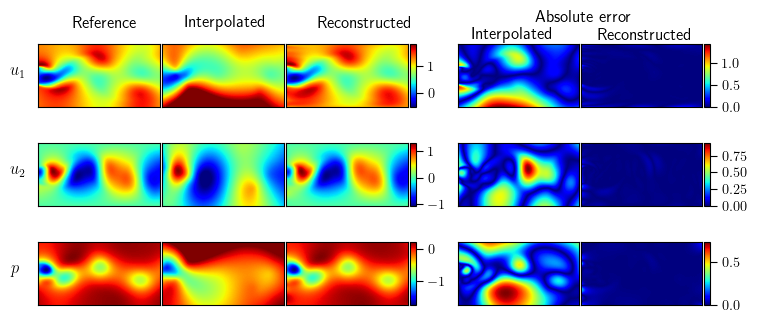

In [47]:
make_image_snapshots(results, '2dtriangle_clean_snapshots', 0,100) 

Probability density

In [143]:
def make_image_pdf(data,figname):

    ## interpolation
    interp_test_nonan = []
    for i in range(3):
        mask = ~np.isnan(data[1][0,...,i])
        interp_test_nonan.append(data[1][...,i][:,mask])

    ## plot
    fig,axes = plt.subplots(1,3,figsize=(7,2.5))
    for i,var in zip(range(3),['$u_1^\prime$','$u_2^\prime$','$p^\prime$']):
        # true
        counts_true,bins_true = np.histogram(data[0][...,i].flatten()-np.mean(data[0][...,i].flatten()), density=True, bins='auto')
        axes[i].stairs(counts_true,bins_true,label='True',linewidth=3, color='#808080',alpha=0.5)
        # interpolation
        counts,bins = np.histogram(interp_test_nonan[i].flatten()-np.mean(interp_test_nonan[i].flatten()), density=True, bins='auto')
        axes[i].stairs(counts,bins,label='Interp.',color='k',linestyle='--')
        
        # prediction
        counts,bins = np.histogram(data[2][...,i].flatten()-np.mean(data[2][...,i].flatten()), density=True, bins='auto')
        axes[i].stairs(counts,bins,label='Predicted',color=my_discrete_cmap(0))
        axes[i].set(xlabel=var)
    axes[0].set_ylabel('Probability density')

    handlers = axes[0].get_legend_handles_labels()
    fig.legend(*handlers,loc='upper center', bbox_to_anchor=(0.5, 1.15),ncols=5)

    # plt.savefig('./figs/'+figname,bbox_inches='tight')
    plt.show()


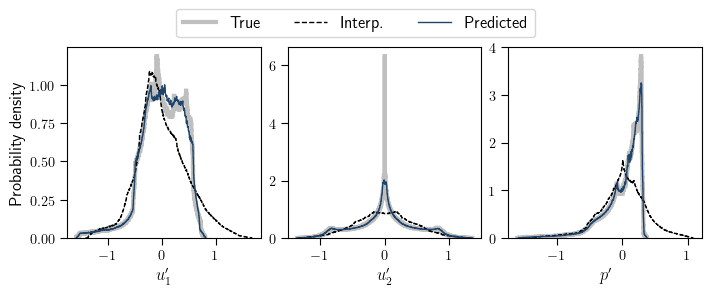

In [144]:
make_image_pdf(results,'2dtriangle_clean_pdf')

Frequency spectrum

In [145]:
var_names = ['$u_1^\prime$','$u_2^\prime$','$p^\prime$']

def make_image_freq(data, figname):

    n = np.prod(data[0].shape[1:-1])

    fftfreq = np.fft.fftfreq(data[0].shape[0],d = dt)
    midpoint = int(len(fftfreq)/2)
    
    # data
    f_data = np.einsum('t x y u -> t u', np.abs(np.fft.fft(data[0]-np.mean(data[0],axis=0),axis=0)))

    # interpolated
    interp_test_nonan = []
    for i in range(3):
        mask = ~np.isnan(data[1][0,...,i])
        interp_test_nonan.append(data[1][...,i][:,mask])
    f_interp = []
    for i in range(3):
        _interp = np.einsum('t n -> t', np.abs(np.fft.fft(interp_test_nonan[i]-np.mean(interp_test_nonan[i]),axis=0)))
        # _interp = _interp / np.std(_interp)
        f_interp.append(_interp)


    fig, axes = plt.subplots(1,3,sharex=True,figsize=(7,2.5))
    for i in range(3):
        axes[i].plot(fftfreq[:midpoint], 2*f_data[:midpoint,i],label='True',linewidth=3,color='#808080',alpha=0.5)
        axes[i].plot(fftfreq[:midpoint], 2*f_interp[i][:midpoint],label='Interp',linewidth=1,color='k',linestyle='--')
        
        f_pred = np.einsum('t x y u -> t u', np.abs(np.fft.fft(data[2]-np.mean(data[2],axis=0),axis=0)))
        axes[i].plot(fftfreq[:midpoint], 2*f_pred[:midpoint,i],label='Predicted',linewidth=1, color=my_discrete_cmap(0))
        axes[i].set(xlabel='$Hz$',title=var_names[i])
        
    axes[0].set(ylabel='Magnitude', xlim=[0,4])
        

    handlers = axes[0].get_legend_handles_labels()
    fig.legend(*handlers,loc='upper center', bbox_to_anchor=(0.5, 1.15),ncols=5)
    # plt.savefig('./figs/'+figname,bbox_inches='tight')
    plt.show()

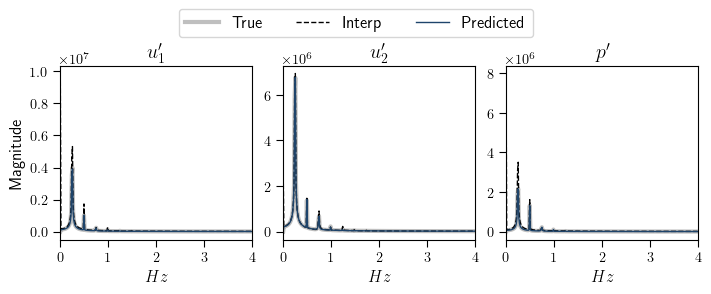

In [146]:
make_image_freq(results,'2dtriangle_clean_freq')

# Sensors

/tmp/ipykernel_28045/522689414.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


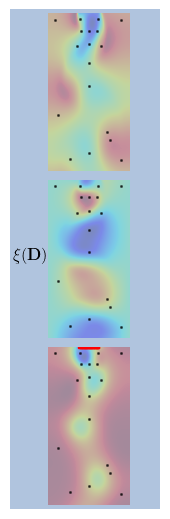

In [139]:
# idx = [[44, 44, 23, 23, 140, 68, 40, 103, 5, 5, 20, 20, 150, 175, 200, 225],[81, 47, 51, 77, 64, 64, 64, 64, 80, 48, 78, 50, 10, 119, 10, 119]]
fig = plt.figure(figsize=(1.5,5))
sfig = fig.subfigures(1,1,facecolor='lightsteelblue')
subfigs = fig.subfigures(1,2,width_ratios=[0.05,0.9],wspace=-0.1,facecolor='lightsteelblue')
axes = subfigs[1].subplots(3,1)
for i in range(3):
    axes[i].imshow(results[0][0,:,:,i],alpha=0.3)
    axes[i].axis('off')
    # axes[i].scatter(idx[1],idx[0],s=3,c='k',marker='s')
    axes[i].spy(observed[0,...,i],color='k',marker='s',markersize=1,alpha=0.6)
axes[2].scatter(range(49,80),[0]*31,marker='s',c='r',s=4, zorder=5)

subfigs[1].text(-0.032,0.5,'$\\xi(\mathbf{D})$')

# fig.savefig('./figs/data_taking_observations',bbox_inches='tight')

fig.show()

In [52]:
loss_interp = losses.relative_error(results[1],results[2])*100
loss_physics_interp = losses.divergence(results[1][...,:-1],datainfo) + losses.momentum_loss(results[1],datainfo)
loss_physics_ref = losses.divergence(results[0][...,:-1],datainfo) + losses.momentum_loss(results[0],datainfo)

print(f'Interpolated relative error(%) from sensors is {loss_interp}')
print(f'Interpolated physics loss from sensors is {loss_physics_interp}')
print(f'Reference data has physics loss {loss_physics_ref}')

Interpolated relative error(%) from sensors is 43.2649165391922
Interpolated physics loss from sensors is 1.0672075748443604
Reference data has physics loss 0.043383900076150894
